In [1]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt

input_image = imread("D:\images\BBBC032_v1_dataset/BMP4blastocystC3-cropped_resampled_8bit_2D.tif")

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


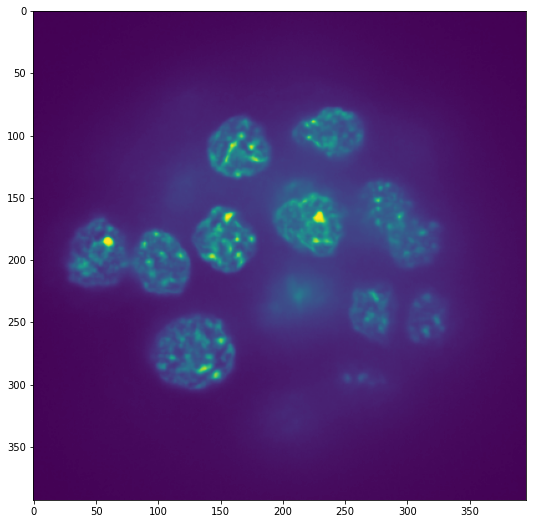

In [2]:
# plot input image
fig, ax = plt.subplots(figsize=(12,9))
ax.imshow(input_image)

r 30.0
size (393, 396)


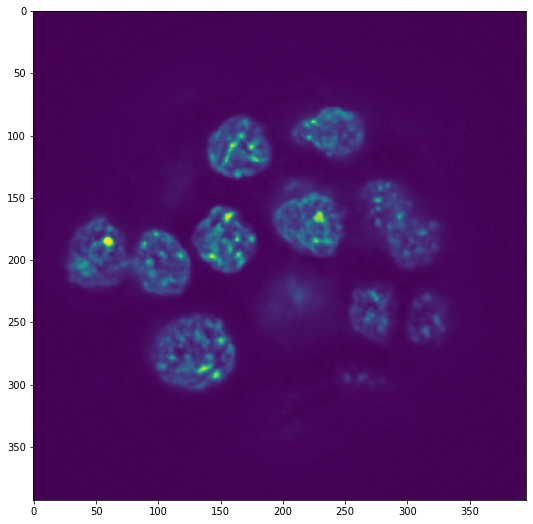

In [13]:
from tnia.background.rolling_ball import rolling_ball_ds
from tnia.background.helper import subtract_clip_negatives
from tnia.background.dilate_subtract import dilate_subtract

# background subtraction
r=30

background = rolling_ball_ds(input_image, r, True, 1, 0)
background_subtracted = subtract_clip_negatives(input_image,background)

fig, ax = plt.subplots(figsize=(12,9))
ax.imshow(background_subtracted)

In [32]:
# apply threshold
import numpy as np
from skimage.morphology import disk
from skimage.filters import median
from tnia.segmentation.thresholding import local_global_threshold
from skimage.filters import threshold_local

# apply a median filter before thresholding
temp=median(input_image, disk(1))  

global_threshold=50

# apply both a local (adaptive) threshold and a global threshold
#thresholded = np.logical_and(temp>threshold_local(temp, 75), temp>global_threshold)
thresholded = local_global_threshold(temp, 75, 50)

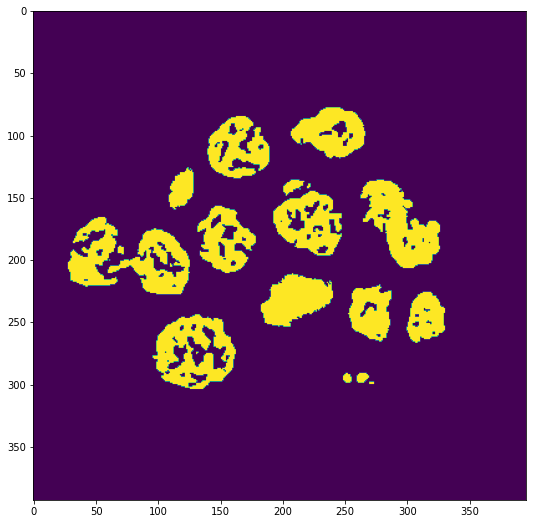

In [33]:
fig, ax = plt.subplots(figsize=(12,9))
ax.imshow(thresholded)

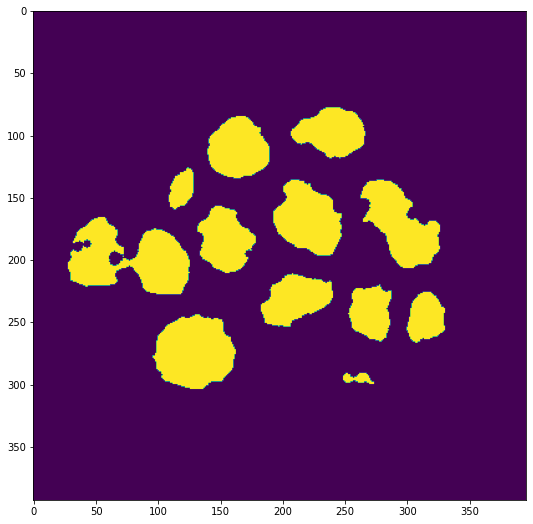

In [40]:
from skimage.morphology import opening, closing
from skimage.morphology import remove_small_holes
from tnia.segmentation.separate import separate_touching

# open the image to smooth edges and separate barely touching object
#thresholded = opening(thresholded, disk(3))

# close the image to fill holes
thresholded = closing(thresholded, disk(3))
thresholded = remove_small_holes(thresholded, 150)

# separate touching objects, input are thresholded, min distance between objects, 
# and number erosions (used to increase separation between objects)
#thresholded = separate_touching(thresholded, 10, 2)

fig, ax = plt.subplots(figsize=(12,9))
ax.imshow(thresholded)

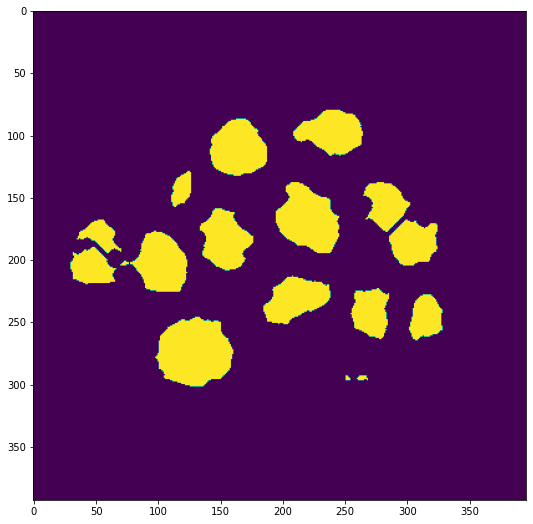

In [41]:
separated = separate_touching(thresholded, 10, 2)
fig, ax = plt.subplots(figsize=(12,9))
ax.imshow(separated)

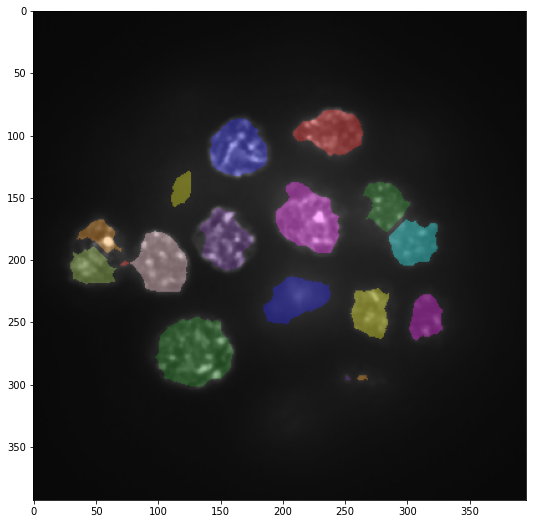

In [43]:
# create label image and show it
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb
label_image = label(separated)
image_label_overlay = label2rgb(label_image, image=temp, bg_label=0)
fig, ax = plt.subplots(figsize=(12,9))
ax.imshow(image_label_overlay)

In [57]:
import math
from tnia.segmentation.filterobjects import find_circular_objects

# in this step we filter the particles using circularity, area and intensity
min_circularity = 0.5
min_area = 100
min_intensity = 50

label_image_filtered = find_circular_objects(input_image, label_image, min_area, min_intensity, min_circularity)
'''
particles=regionprops(label_image,input_image)

label_image_filtered=label_image.copy()
labels = np.arange(np.max(label_image)+1)
for particle in particles:
    circularity = 4*math.pi*(particle.area/particle.perimeter**2)    
    if circularity < max_circularity or particle.area < max_area or particle.mean_intensity<max_intensity:
        label_image_filtered[label_image_filtered==particle.label]=0
'''        

'\nparticles=regionprops(label_image,input_image)\n\nlabel_image_filtered=label_image.copy()\nlabels = np.arange(np.max(label_image)+1)\nfor particle in particles:\n    circularity = 4*math.pi*(particle.area/particle.perimeter**2)    \n    if circularity < max_circularity or particle.area < max_area or particle.mean_intensity<max_intensity:\n        label_image_filtered[label_image_filtered==particle.label]=0\n'

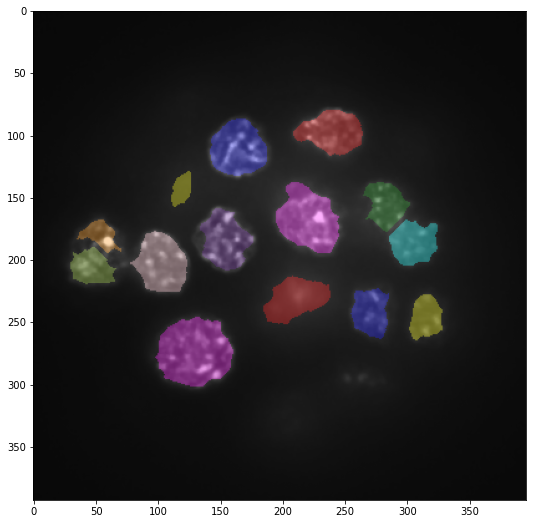

In [58]:
image_label_overlay = label2rgb(label_image_filtered, image=temp, bg_label=0)
fig, ax = plt.subplots(figsize=(12,9))
ax.imshow(image_label_overlay)